## Hyperparameter Tuning

The hyperparameters in deep learning to tune are 
- the number of neurons
- activation function
- optimiser
- learning rate
- batch size
- epochs 
- number of layers.


Reference: 
- https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

In [ ]:
from typing import List, Optional, Callable
import os
import sys
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from torch.hub import load_state_dict_from_url
from torchvision.models._api import WeightsEnum
from timm.models.swin_transformer import SwinTransformer



import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

# determine the project root - required to import DataHandler from utils folder
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# configuring log file
log_dir = os.path.join(project_root, "logs")
os.makedirs(log_dir, exist_ok=True)
log_filename = os.path.join(log_dir, "SwinFicientNet_best_model_training_log.txt") #NOTE: specify based on model training

logging.basicConfig(
    filename=log_filename,
    filemode="w",  #NOTE: previous logs would be overwritten
    format="%(asctime)s %(levelname)s: %(message)s",
    level=logging.INFO
)

MODEL_SAVE_DIR = os.path.join(project_root, "models", "SwinFicientNet_best_model")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) 

from utils.DataHandler import download_dataset, create_full_data_loaders, create_tuning_data_loaders

c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-18 16:26:40,562	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-18 16:26:40,720	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
def get_device():
    if torch.cuda.is_available():
        print("Using device: CUDA (GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using device: MPS (Apple Silicon GPU)")
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        return torch.device("mps")
    else:
        print("Using device: CPU")
        return torch.device("cpu")

device = get_device()

Using device: CUDA (GPU)


## Data Download
This is adapted from SeparatingData.ipynb
Download the processed dataset from Google Drive if yet to.

In [ ]:
# DATA_DIR = "../input/final_split_training_augmented"
# ZIP_URL = "https://drive.google.com/uc?id=11t8m703wcNss3w5diJSUGBA_vXnCKChr"
# ZIP_FILENAME = "../input/final_split.zip"
# ROOT_DIR = "../input"

# download_dataset(DATA_DIR, ZIP_URL, ZIP_FILENAME, ROOT_DIR)

Dataset already exists at ../input/final_split_training_augmented


## Subset Data Load
For faster hyperparameter tuning, use a subset of the dataset to find the most optimised set of hyperparameters.
Loads dataset from processed dataset which should have been split to train, test, eval.

In [4]:
SPLIT_DATASET = os.path.abspath("../../input/final_split_15Apr2025")
BATCH_SIZE = 64

# Define data transformation 
# in this notebook, we are doing it for EfficientNetB5, so we resize to ~456x456
weights = EfficientNet_B5_Weights.DEFAULT
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    weights.transforms()
])

TRAIN_LOADER, VAL_LOADER, TEST_LOADER = create_tuning_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
    subset_fraction=0.5,
    random_seed=42
)

Using pre-split datasets: train 8025, val 579, test 572
Created tuning data loaders with subset fraction: 0.5
Created subset datasets for hyperparameter tuning: train 4012, val 289, test 572
Class Distribution for Subset Training:
  angry     : 983
  happy     : 1039
  relaxed   : 1024
  sad       : 966
Class Distribution for Subset Validation:
  angry     : 71
  happy     : 75
  relaxed   : 74
  sad       : 69


## Full Data Load
When doing the entire training for the entire dataset (full dataset not used in hyperparameter tuning)

In [5]:
FULL_TRAIN_LOADER, FULL_VAL_LOADER, FULL_TEST_LOADER = create_full_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
)

Using pre-split datasets: train 8025, val 579, test 572


## Model Specifications
This is where you should replace with your model.

SwinFicientNet_best_model Partial Transfer Learning:
- https://discuss.pytorch.org/t/partial-transfer-learning-efficientnet/109689 

In [ ]:
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




class SwinFicientNet(nn.Module):
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu',
                 use_se: bool = True,
                 unfreeze_blocks: Optional[List[int]] = None):
        super().__init__()

        # 1) EfficientNet-B5 feature extractor only
        eff = efficientnet_b5(weights=EfficientNet_B5_Weights.DEFAULT)
        self.backbone = eff.features  # <-- 4D conv maps
        feat_channels = 2048          # EfficientNetB5's final feature‐map channels

        # Freeze all EfficientNet layers, then optionally unfreeze some
        for p in self.backbone.parameters():
            p.requires_grad = False
        if unfreeze_blocks:
            for idx in unfreeze_blocks:
                for p in self.backbone[idx].parameters():
                    p.requires_grad = True

        # 2) Squeeze‐Excitation on the conv maps
        self.se = SqueezeExcitationBlock(feat_channels)

        # 3) Project into 96 channels for Swin
        self.project    = nn.Conv2d(feat_channels, 96, kernel_size=1)
        self.adapt_pool = nn.AdaptiveAvgPool2d((14, 14))

        # 4) Swin Transformer head (classifier baked in)
        self.swin = SwinTransformer(
            img_size=14,
            patch_size=1,
            in_chans=96,
            embed_dim=96,
            depths=[2, 2, 6, 2],
            num_heads=[3, 6, 12, 24],
            window_size=7,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_path_rate=0.1,
            ape=False,
            patch_norm=True,
            num_classes=num_classes
        )

        # 5) Optional extra MLP (if you want more hidden layers after Swin)
        layers = []
        if hidden_sizes:
            inp = num_classes
            for h in hidden_sizes:
                layers += [
                    nn.Dropout(dropout),
                    nn.Linear(inp, h),
                    self._get_activation(activation)
                ]
                inp = h
            layers += [nn.Dropout(dropout), nn.Linear(inp, num_classes)]
            self.post_swin = nn.Sequential(*layers)
        else:
            self.post_swin = nn.Identity()

    def _get_activation(self, act: str) -> nn.Module:
        act = act.lower()
        return {
            'relu'     : nn.ReLU(),
            'tanh'     : nn.Tanh(),
            'sigmoid'  : nn.Sigmoid(),
            'leakyrelu': nn.LeakyReLU()
        }[act]

    def forward(self, x):
        x = self.backbone(x)    # [B, 2048, H, W]
        x = self.se(x)          # SE block
        x = self.project(x)     # [B,  96, H, W]
        x = self.adapt_pool(x)  # [B,  96, 14,14]
        x = self.swin(x)        # [B, num_classes]
        return self.post_swin(x)


In [9]:
print(f"Using device: {device}")
model = SwinFicientNet(num_classes=4, dropout=0.3, hidden_sizes=[256, 128], activation='relu', unfreeze_blocks=[7]).to(device)
print("Model instantiated:", model.__class__.__name__)
print(model)

Using device: cuda
Model instantiated: SwinFicientNet
SwinFicientNet(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activat

## Hyperparameter Tuning
This is the part where you write the training function and load it to the ray tune scheduler.
For this execution, ASHAscheduler is used with Optuna for bayesian optimisation techniques - which should be using the default Tree-Structured Parzen Estimator.
If many parameters, this is would be more efficient than grid search and random search.

References:
- https://docs.ray.io/en/latest/tune/examples/includes/async_hyperband_example.html
- https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html 
- https://docs.ray.io/en/latest/tune/examples/includes/mnist_pytorch.html
- https://docs.ray.io/en/latest/tune/api/suggestion.html

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from ray import tune

CHECKPOINT_DIR = os.path.abspath("../../models/hyptune/swinNetB5")
def train_model(config, checkpoint_dir=CHECKPOINT_DIR, data_dir=None):
    """Training function for Ray Tune hyperparameter tuning.

    This function instantiates the model with hyperparameters
    specified in the config dictionary, trains the model on the global TRAIN_LOADER,
    evaluates on VAL_LOADER, and reports the validation loss to Ray Tune.

    Args:
        config (dict): Hyperparameter configuration. Expected keys include:
            - lr (float): Learning rate.
            - weight_decay (float): Weight decay for the optimizer.
            - dropout (float): Dropout rate for the classifier.
            - hidden_sizes (list or None): List of hidden layer sizes in the classifier.
            - activation (str): Activation function to use ('relu', 'tanh', etc.).
            - freeze_backbone (bool): Whether to freeze the model backbone.
            - num_epochs (int): Number of training epochs.
            - optimiser (callable, optional): Optimiser class. Default is optim.Adam.
            - criterion (callable, optional): Loss function instance. Default is nn.CrossEntropyLoss().
        checkpoint_dir (str, optional): Directory for checkpointing (if applicable).
        data_dir (str, optional): Not used here; included for compatibility.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Checkpoint Folder exists")
    
    # instantiate model with hyperparameters from config
    model = SwinFicientNet(
        num_classes=4,
        dropout=config.get("dropout", 0.3),
        hidden_sizes=config.get("hidden_sizes", None),
        activation=config.get("activation", "relu"),
        unfreeze_blocks = config.get("unfreeze_blocks", [7])
    ).to(device)

    optimiser = config["optimiser"](model.parameters(), config["lr"], config["weight_decay"])
    criterion = config["criterion"]()

    num_epochs = config.get("num_epochs", 2)  # a low number for quick tuning, but update accordingly
    
    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in tqdm(TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(TRAIN_LOADER.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
        
        # optionally, can checkpoint the model
        if checkpoint_dir:
            path = os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pt")
            torch.save(model.state_dict(), path)
    
    # evaluation on the subset validation set
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
    
    avg_val_loss = total_loss / len(VAL_LOADER.dataset)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    
    # Report the metric to Ray Tune
    tune.report({"loss": avg_val_loss})

In [11]:
asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='loss',
    mode='min',
    max_t=100,           # max training iterations per trial
    grace_period=10,     # min iterations before stopping
    reduction_factor=3,
    brackets=1,
)

optuna_search = OptunaSearch(metric="loss", mode="min", seed=42)

# define search space in a config dictionary, i.e what are the values you want to try, this is just example of format
'''
config = {
    "lr": tune.loguniform(1e-5, 1e-2),
    "weight_decay": tune.loguniform(1e-6, 1e-2),
    "dropout": tune.uniform(0.1, 0.5),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh"]),
    "freeze_backbone": tune.choice([True, False]),
    "num_epochs": 2, 
    "optimiser": tune.choice([optim.Adam, optim.SGD]),
    "criterion": tune.choice([nn.CrossEntropyLoss, nn.NLLLoss]),
    "unfreeze_blocks": tune.choice([[7], [6, 7], [5, 6, 7]]),
}
'''

# this is what i specified for the example because i am running on cpu
# config = {
#     "lr": tune.loguniform(1e-5, 1e-2),
#     "weight_decay": tune.loguniform(1e-6, 1e-2),
#     "dropout": tune.uniform(0.1, 0.5),
#     "freeze_backbone": tune.choice([True]),
#     "num_epochs": 2,
# }


# for efficientnetb5 gpu
config = {
    "lr": tune.loguniform(1e-5, 5e-5),    
    "weight_decay": tune.loguniform(1e-5, 1e-4),
    "dropout": tune.uniform(0.3, 0.5),
    "hidden_sizes": tune.choice([None]), #[256, 128], [512, 256], 
    "activation": tune.choice(["relu", "tanh", "sigmoid", "leakyrelu"]), #Removed gelu
    "unfreeze_blocks": tune.choice([[6, 7]]),
    "num_epochs": 10,
    "optimiser": tune.choice([
        lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
        lambda params, lr, wd: optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    ]),
    "criterion": lambda: nn.CrossEntropyLoss()
}

def trial_dirname_creator(trial):
    # this is meant to create short and unique directory name for each trial bc else too long for windows
    # include a unique identifier (like trial.trial_id).
    return f"trial_{trial.trial_id}"

def trial_name_creator(trial):
    return f"t_{trial.trial_id}"

# tuner object
tuner = tune.Tuner(
    tune.with_resources(train_model, {"cpu": 2, "gpu": 1}), #NOTE:specify based on the device u using because by default it uses all, i.e if u have 4 cpus; it does 4 concurrent trials
    tune_config=tune.TuneConfig(
        scheduler=asha_scheduler,
        search_alg=optuna_search,
        num_samples=15,  # number of trials to run
        trial_dirname_creator=trial_dirname_creator,
        trial_name_creator=trial_name_creator, 
    ),
    run_config=tune.RunConfig(
        name="SwinFicientNet",
        storage_path="C:/ray_results/SwinFicientNet", #NOTE: not required for macos
        log_to_file=True,
        verbose=1),
    param_space=config,
)

results = tuner.fit()
print("Best config:", results.get_best_result(metric="loss", mode="min", filter_nan_and_inf=False).config)

(train_model pid=13456) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [02:31<00:00,  2.41s/it]


(train_model pid=13456) Epoch 1/10, Training Loss: 1.2515


Epoch 2/10: 100%|██████████| 63/63 [02:29<00:00,  2.37s/it]


(train_model pid=13456) Epoch 2/10, Training Loss: 0.8390


Epoch 3/10: 100%|██████████| 63/63 [02:28<00:00,  2.36s/it]


(train_model pid=13456) Epoch 3/10, Training Loss: 0.5930


Epoch 4/10: 100%|██████████| 63/63 [02:26<00:00,  2.32s/it]


(train_model pid=13456) Epoch 4/10, Training Loss: 0.4214


Epoch 5/10: 100%|██████████| 63/63 [02:26<00:00,  2.33s/it]


(train_model pid=13456) Epoch 5/10, Training Loss: 0.3493


Epoch 6/10: 100%|██████████| 63/63 [02:26<00:00,  2.33s/it]


(train_model pid=13456) Epoch 6/10, Training Loss: 0.2723


Epoch 7/10: 100%|██████████| 63/63 [02:26<00:00,  2.32s/it]


(train_model pid=13456) Epoch 7/10, Training Loss: 0.2225


Epoch 8/10: 100%|██████████| 63/63 [02:25<00:00,  2.31s/it]


(train_model pid=13456) Epoch 8/10, Training Loss: 0.1777


Epoch 9/10: 100%|██████████| 63/63 [02:26<00:00,  2.32s/it]


(train_model pid=13456) Epoch 9/10, Training Loss: 0.1501


Epoch 10/10: 100%|██████████| 63/63 [02:26<00:00,  2.32s/it]


(train_model pid=13456) Epoch 10/10, Training Loss: 0.1057


2025-04-18 16:52:38,383	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=13456) Validation Loss: 0.7857
(train_model pid=5124) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [02:44<00:00,  2.61s/it]


(train_model pid=5124) Epoch 1/10, Training Loss: 1.4050


Epoch 2/10: 100%|██████████| 63/63 [02:27<00:00,  2.34s/it]


(train_model pid=5124) Epoch 2/10, Training Loss: 1.3818


Epoch 3/10: 100%|██████████| 63/63 [02:27<00:00,  2.35s/it]


(train_model pid=5124) Epoch 3/10, Training Loss: 1.3657


Epoch 4/10: 100%|██████████| 63/63 [02:28<00:00,  2.36s/it]


(train_model pid=5124) Epoch 4/10, Training Loss: 1.3527


Epoch 5/10: 100%|██████████| 63/63 [02:27<00:00,  2.34s/it]


(train_model pid=5124) Epoch 5/10, Training Loss: 1.3336


Epoch 6/10: 100%|██████████| 63/63 [02:27<00:00,  2.34s/it]


(train_model pid=5124) Epoch 6/10, Training Loss: 1.3168


Epoch 7/10: 100%|██████████| 63/63 [02:27<00:00,  2.34s/it]


(train_model pid=5124) Epoch 7/10, Training Loss: 1.3026


Epoch 8/10: 100%|██████████| 63/63 [02:27<00:00,  2.35s/it]


(train_model pid=5124) Epoch 8/10, Training Loss: 1.2845


Epoch 9/10: 100%|██████████| 63/63 [02:27<00:00,  2.35s/it]


(train_model pid=5124) Epoch 9/10, Training Loss: 1.2670


Epoch 10/10:  98%|█████████▊| 62/63 [02:25<00:02,  2.34s/it]


(train_model pid=5124) Epoch 10/10, Training Loss: 1.2451


Epoch 10/10: 100%|██████████| 63/63 [02:27<00:00,  2.34s/it]
2025-04-18 17:17:47,068	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=5124) Validation Loss: 1.2408
(train_model pid=4792) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [02:11<00:00,  2.08s/it]


(train_model pid=4792) Epoch 1/10, Training Loss: 1.2081


Epoch 2/10: 100%|██████████| 63/63 [02:09<00:00,  2.06s/it]


(train_model pid=4792) Epoch 2/10, Training Loss: 0.8378


Epoch 3/10: 100%|██████████| 63/63 [02:09<00:00,  2.06s/it]


(train_model pid=4792) Epoch 3/10, Training Loss: 0.5876


Epoch 4/10: 100%|██████████| 63/63 [02:11<00:00,  2.08s/it]


(train_model pid=4792) Epoch 4/10, Training Loss: 0.4302


Epoch 5/10: 100%|██████████| 63/63 [02:10<00:00,  2.06s/it]


(train_model pid=4792) Epoch 5/10, Training Loss: 0.3319


Epoch 6/10: 100%|██████████| 63/63 [02:09<00:00,  2.06s/it]


(train_model pid=4792) Epoch 6/10, Training Loss: 0.2394


Epoch 7/10:  98%|█████████▊| 62/63 [02:07<00:02,  2.06s/it]


(train_model pid=4792) Epoch 7/10, Training Loss: 0.1998


Epoch 8/10: 100%|██████████| 63/63 [02:09<00:00,  2.05s/it]


(train_model pid=4792) Epoch 8/10, Training Loss: 0.1902


Epoch 9/10: 100%|██████████| 63/63 [02:09<00:00,  2.06s/it]


(train_model pid=4792) Epoch 9/10, Training Loss: 0.1209


Epoch 10/10: 100%|██████████| 63/63 [02:09<00:00,  2.06s/it]


(train_model pid=4792) Epoch 10/10, Training Loss: 0.1061


2025-04-18 17:39:37,736	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=4792) Validation Loss: 0.5820
(train_model pid=30596) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [02:11<00:00,  2.08s/it]


(train_model pid=30596) Epoch 1/10, Training Loss: 1.2421


Epoch 2/10: 100%|██████████| 63/63 [02:09<00:00,  2.05s/it]


(train_model pid=30596) Epoch 2/10, Training Loss: 0.8132


Epoch 3/10: 100%|██████████| 63/63 [02:09<00:00,  2.06s/it]


(train_model pid=30596) Epoch 3/10, Training Loss: 0.5586


Epoch 4/10: 100%|██████████| 63/63 [02:09<00:00,  2.06s/it]


(train_model pid=30596) Epoch 4/10, Training Loss: 0.3980


Epoch 5/10: 100%|██████████| 63/63 [02:09<00:00,  2.06s/it]


(train_model pid=30596) Epoch 5/10, Training Loss: 0.3059


Epoch 6/10: 100%|██████████| 63/63 [02:09<00:00,  2.06s/it]


(train_model pid=30596) Epoch 6/10, Training Loss: 0.2346


Epoch 7/10: 100%|██████████| 63/63 [02:10<00:00,  2.07s/it]


(train_model pid=30596) Epoch 7/10, Training Loss: 0.1776


Epoch 8/10: 100%|██████████| 63/63 [02:10<00:00,  2.06s/it]


(train_model pid=30596) Epoch 8/10, Training Loss: 0.1401


Epoch 9/10: 100%|██████████| 63/63 [02:10<00:00,  2.07s/it]


(train_model pid=30596) Epoch 9/10, Training Loss: 0.1066


Epoch 10/10: 100%|██████████| 63/63 [02:09<00:00,  2.06s/it]


(train_model pid=30596) Epoch 10/10, Training Loss: 0.1000


2025-04-18 18:01:28,922	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=30596) Validation Loss: 0.6193
(train_model pid=5840) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:53<00:00,  1.81s/it]


(train_model pid=5840) Epoch 1/10, Training Loss: 1.2545


Epoch 2/10: 100%|██████████| 63/63 [01:52<00:00,  1.78s/it]


(train_model pid=5840) Epoch 2/10, Training Loss: 0.8742


Epoch 3/10: 100%|██████████| 63/63 [01:52<00:00,  1.78s/it]


(train_model pid=5840) Epoch 3/10, Training Loss: 0.6456


Epoch 4/10: 100%|██████████| 63/63 [01:52<00:00,  1.78s/it]


(train_model pid=5840) Epoch 4/10, Training Loss: 0.4922


Epoch 5/10:  98%|█████████▊| 62/63 [01:50<00:01,  1.78s/it]


(train_model pid=5840) Epoch 5/10, Training Loss: 0.4030


Epoch 6/10: 100%|██████████| 63/63 [01:52<00:00,  1.78s/it]


(train_model pid=5840) Epoch 6/10, Training Loss: 0.2968


Epoch 7/10: 100%|██████████| 63/63 [01:51<00:00,  1.78s/it]


(train_model pid=5840) Epoch 7/10, Training Loss: 0.2345


Epoch 8/10: 100%|██████████| 63/63 [01:51<00:00,  1.78s/it]


(train_model pid=5840) Epoch 8/10, Training Loss: 0.2106


Epoch 9/10: 100%|██████████| 63/63 [01:52<00:00,  1.78s/it]


(train_model pid=5840) Epoch 9/10, Training Loss: 0.1551


Epoch 10/10: 100%|██████████| 63/63 [01:52<00:00,  1.78s/it]


(train_model pid=5840) Epoch 10/10, Training Loss: 0.1569


2025-04-18 18:20:22,680	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=5840) Validation Loss: 0.5823
(train_model pid=19516) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:54<00:00,  1.81s/it]


(train_model pid=19516) Epoch 1/10, Training Loss: 1.2065


Epoch 2/10: 100%|██████████| 63/63 [01:52<00:00,  1.79s/it]


(train_model pid=19516) Epoch 2/10, Training Loss: 0.7477


Epoch 3/10: 100%|██████████| 63/63 [01:52<00:00,  1.79s/it]


(train_model pid=19516) Epoch 3/10, Training Loss: 0.4837


Epoch 4/10: 100%|██████████| 63/63 [01:52<00:00,  1.78s/it]


(train_model pid=19516) Epoch 4/10, Training Loss: 0.3308


Epoch 5/10: 100%|██████████| 63/63 [01:51<00:00,  1.78s/it]


(train_model pid=19516) Epoch 5/10, Training Loss: 0.2650


Epoch 6/10: 100%|██████████| 63/63 [01:51<00:00,  1.78s/it]


(train_model pid=19516) Epoch 6/10, Training Loss: 0.1617


Epoch 7/10: 100%|██████████| 63/63 [01:52<00:00,  1.79s/it]


(train_model pid=19516) Epoch 7/10, Training Loss: 0.1285


Epoch 8/10: 100%|██████████| 63/63 [01:52<00:00,  1.79s/it]


(train_model pid=19516) Epoch 8/10, Training Loss: 0.1107


Epoch 9/10:  98%|█████████▊| 62/63 [01:51<00:01,  1.78s/it]


(train_model pid=19516) Epoch 9/10, Training Loss: 0.0828


Epoch 10/10: 100%|██████████| 63/63 [01:52<00:00,  1.78s/it]


(train_model pid=19516) Epoch 10/10, Training Loss: 0.0791


2025-04-18 18:39:19,137	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=19516) Validation Loss: 0.7184
(train_model pid=8968) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:57<00:00,  1.86s/it]


(train_model pid=8968) Epoch 1/10, Training Loss: 1.4056


Epoch 2/10: 100%|██████████| 63/63 [01:53<00:00,  1.79s/it]


(train_model pid=8968) Epoch 2/10, Training Loss: 1.3870


Epoch 3/10: 100%|██████████| 63/63 [01:52<00:00,  1.79s/it]


(train_model pid=8968) Epoch 3/10, Training Loss: 1.3692


Epoch 4/10: 100%|██████████| 63/63 [01:52<00:00,  1.79s/it]


(train_model pid=8968) Epoch 4/10, Training Loss: 1.3535


Epoch 5/10: 100%|██████████| 63/63 [01:53<00:00,  1.80s/it]


(train_model pid=8968) Epoch 5/10, Training Loss: 1.3385


Epoch 6/10: 100%|██████████| 63/63 [01:53<00:00,  1.80s/it]


(train_model pid=8968) Epoch 6/10, Training Loss: 1.3229


Epoch 7/10: 100%|██████████| 63/63 [01:53<00:00,  1.80s/it]


(train_model pid=8968) Epoch 7/10, Training Loss: 1.3068


Epoch 8/10: 100%|██████████| 63/63 [01:53<00:00,  1.79s/it]


(train_model pid=8968) Epoch 8/10, Training Loss: 1.2793


Epoch 9/10:  98%|█████████▊| 62/63 [01:51<00:01,  1.80s/it]


(train_model pid=8968) Epoch 9/10, Training Loss: 1.2694


Epoch 10/10: 100%|██████████| 63/63 [01:53<00:00,  1.80s/it]


(train_model pid=8968) Epoch 10/10, Training Loss: 1.2407


2025-04-18 18:58:26,910	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=8968) Validation Loss: 1.2168
(train_model pid=14016) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:54<00:00,  1.81s/it]


(train_model pid=14016) Epoch 1/10, Training Loss: 1.2526


Epoch 2/10: 100%|██████████| 63/63 [01:52<00:00,  1.79s/it]


(train_model pid=14016) Epoch 2/10, Training Loss: 0.8615


Epoch 3/10: 100%|██████████| 63/63 [01:52<00:00,  1.78s/it]


(train_model pid=14016) Epoch 3/10, Training Loss: 0.6456


Epoch 4/10:  98%|█████████▊| 62/63 [01:50<00:01,  1.78s/it]


(train_model pid=14016) Epoch 4/10, Training Loss: 0.4477


Epoch 5/10: 100%|██████████| 63/63 [01:51<00:00,  1.78s/it]


(train_model pid=14016) Epoch 5/10, Training Loss: 0.3730


Epoch 6/10: 100%|██████████| 63/63 [01:51<00:00,  1.78s/it]


(train_model pid=14016) Epoch 6/10, Training Loss: 0.2679


Epoch 7/10: 100%|██████████| 63/63 [01:52<00:00,  1.78s/it]


(train_model pid=14016) Epoch 7/10, Training Loss: 0.2163


Epoch 8/10: 100%|██████████| 63/63 [01:51<00:00,  1.78s/it]


(train_model pid=14016) Epoch 8/10, Training Loss: 0.1895


Epoch 9/10: 100%|██████████| 63/63 [01:51<00:00,  1.78s/it]


(train_model pid=14016) Epoch 9/10, Training Loss: 0.1562


Epoch 10/10: 100%|██████████| 63/63 [01:51<00:00,  1.78s/it]


(train_model pid=14016) Epoch 10/10, Training Loss: 0.1214


2025-04-18 19:17:20,624	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=14016) Validation Loss: 0.7175
(train_model pid=29976) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:53<00:00,  1.81s/it]


(train_model pid=29976) Epoch 1/10, Training Loss: 1.4255


Epoch 2/10: 100%|██████████| 63/63 [01:49<00:00,  1.74s/it]


(train_model pid=29976) Epoch 2/10, Training Loss: 1.4042


Epoch 3/10: 100%|██████████| 63/63 [01:49<00:00,  1.74s/it]


(train_model pid=29976) Epoch 3/10, Training Loss: 1.3969


Epoch 4/10: 100%|██████████| 63/63 [01:49<00:00,  1.74s/it]


(train_model pid=29976) Epoch 4/10, Training Loss: 1.3887


Epoch 5/10: 100%|██████████| 63/63 [01:49<00:00,  1.74s/it]


(train_model pid=29976) Epoch 5/10, Training Loss: 1.3797


Epoch 6/10: 100%|██████████| 63/63 [01:49<00:00,  1.74s/it]


(train_model pid=29976) Epoch 6/10, Training Loss: 1.3726


Epoch 7/10:  98%|█████████▊| 62/63 [01:48<00:01,  1.75s/it]


(train_model pid=29976) Epoch 7/10, Training Loss: 1.3676


Epoch 8/10: 100%|██████████| 63/63 [01:49<00:00,  1.74s/it]


(train_model pid=29976) Epoch 8/10, Training Loss: 1.3598


Epoch 9/10: 100%|██████████| 63/63 [01:49<00:00,  1.74s/it]


(train_model pid=29976) Epoch 9/10, Training Loss: 1.3548


Epoch 10/10: 100%|██████████| 63/63 [01:49<00:00,  1.74s/it]


(train_model pid=29976) Epoch 10/10, Training Loss: 1.3520


2025-04-18 19:35:54,528	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=29976) Validation Loss: 1.3384
(train_model pid=24916) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:50<00:00,  1.75s/it]


(train_model pid=24916) Epoch 1/10, Training Loss: 1.2112


Epoch 2/10:  98%|█████████▊| 62/63 [01:46<00:01,  1.72s/it]


(train_model pid=24916) Epoch 2/10, Training Loss: 0.7609


Epoch 3/10: 100%|██████████| 63/63 [01:48<00:00,  1.72s/it]


(train_model pid=24916) Epoch 3/10, Training Loss: 0.4783


Epoch 4/10: 100%|██████████| 63/63 [01:48<00:00,  1.72s/it]


(train_model pid=24916) Epoch 4/10, Training Loss: 0.3377


Epoch 5/10: 100%|██████████| 63/63 [01:48<00:00,  1.72s/it]


(train_model pid=24916) Epoch 5/10, Training Loss: 0.2545


Epoch 6/10: 100%|██████████| 63/63 [01:48<00:00,  1.72s/it]


(train_model pid=24916) Epoch 6/10, Training Loss: 0.1787


Epoch 7/10: 100%|██████████| 63/63 [01:48<00:00,  1.72s/it]


(train_model pid=24916) Epoch 7/10, Training Loss: 0.1542


Epoch 8/10: 100%|██████████| 63/63 [01:48<00:00,  1.72s/it]


(train_model pid=24916) Epoch 8/10, Training Loss: 0.1215


Epoch 9/10: 100%|██████████| 63/63 [01:48<00:00,  1.71s/it]


(train_model pid=24916) Epoch 9/10, Training Loss: 0.1057


Epoch 10/10: 100%|██████████| 63/63 [01:47<00:00,  1.71s/it]


(train_model pid=24916) Epoch 10/10, Training Loss: 0.0680


2025-04-18 19:54:10,030	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=24916) Validation Loss: 0.7889
(train_model pid=28900) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:46<00:00,  1.70s/it]


(train_model pid=28900) Epoch 1/10, Training Loss: 1.2787


Epoch 2/10:  98%|█████████▊| 62/63 [01:43<00:01,  1.67s/it]


(train_model pid=28900) Epoch 2/10, Training Loss: 0.9716


Epoch 3/10: 100%|██████████| 63/63 [01:45<00:00,  1.67s/it]


(train_model pid=28900) Epoch 3/10, Training Loss: 0.7709


Epoch 4/10: 100%|██████████| 63/63 [01:45<00:00,  1.67s/it]


(train_model pid=28900) Epoch 4/10, Training Loss: 0.5924


Epoch 5/10: 100%|██████████| 63/63 [01:45<00:00,  1.67s/it]


(train_model pid=28900) Epoch 5/10, Training Loss: 0.4715


Epoch 6/10: 100%|██████████| 63/63 [01:45<00:00,  1.67s/it]


(train_model pid=28900) Epoch 6/10, Training Loss: 0.4131


Epoch 7/10: 100%|██████████| 63/63 [01:45<00:00,  1.67s/it]


(train_model pid=28900) Epoch 7/10, Training Loss: 0.3458


Epoch 8/10: 100%|██████████| 63/63 [01:45<00:00,  1.67s/it]


(train_model pid=28900) Epoch 8/10, Training Loss: 0.2922


Epoch 9/10: 100%|██████████| 63/63 [01:45<00:00,  1.67s/it]


(train_model pid=28900) Epoch 9/10, Training Loss: 0.2543


Epoch 10/10: 100%|██████████| 63/63 [01:45<00:00,  1.67s/it]


(train_model pid=28900) Epoch 10/10, Training Loss: 0.2139


2025-04-18 20:11:55,144	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=28900) Validation Loss: 0.7207
(train_model pid=24228) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:50<00:00,  1.75s/it]


(train_model pid=24228) Epoch 1/10, Training Loss: 1.4105


Epoch 2/10: 100%|██████████| 63/63 [01:46<00:00,  1.69s/it]


(train_model pid=24228) Epoch 2/10, Training Loss: 1.3744


Epoch 3/10: 100%|██████████| 63/63 [01:46<00:00,  1.69s/it]


(train_model pid=24228) Epoch 3/10, Training Loss: 1.3509


Epoch 4/10: 100%|██████████| 63/63 [01:47<00:00,  1.70s/it]


(train_model pid=24228) Epoch 4/10, Training Loss: 1.3302


Epoch 5/10: 100%|██████████| 63/63 [01:46<00:00,  1.69s/it]


(train_model pid=24228) Epoch 5/10, Training Loss: 1.3014


Epoch 6/10: 100%|██████████| 63/63 [01:46<00:00,  1.69s/it]


(train_model pid=24228) Epoch 6/10, Training Loss: 1.2832


Epoch 7/10: 100%|██████████| 63/63 [01:46<00:00,  1.69s/it]


(train_model pid=24228) Epoch 7/10, Training Loss: 1.2593


Epoch 8/10: 100%|██████████| 63/63 [01:46<00:00,  1.69s/it]


(train_model pid=24228) Epoch 8/10, Training Loss: 1.2250


Epoch 9/10: 100%|██████████| 63/63 [01:46<00:00,  1.69s/it]


(train_model pid=24228) Epoch 9/10, Training Loss: 1.1937


Epoch 10/10: 100%|██████████| 63/63 [01:46<00:00,  1.69s/it]


(train_model pid=24228) Epoch 10/10, Training Loss: 1.1541


2025-04-18 20:29:58,064	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=24228) Validation Loss: 1.1449
(train_model pid=29544) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:47<00:00,  1.70s/it]


(train_model pid=29544) Epoch 1/10, Training Loss: 1.1963


Epoch 2/10: 100%|██████████| 63/63 [01:45<00:00,  1.68s/it]


(train_model pid=29544) Epoch 2/10, Training Loss: 0.6233


Epoch 3/10: 100%|██████████| 63/63 [01:45<00:00,  1.68s/it]


(train_model pid=29544) Epoch 3/10, Training Loss: 0.4015


Epoch 4/10: 100%|██████████| 63/63 [01:45<00:00,  1.68s/it]


(train_model pid=29544) Epoch 4/10, Training Loss: 0.2219


Epoch 5/10: 100%|██████████| 63/63 [01:46<00:00,  1.68s/it]


(train_model pid=29544) Epoch 5/10, Training Loss: 0.2078


Epoch 6/10: 100%|██████████| 63/63 [01:45<00:00,  1.67s/it]


(train_model pid=29544) Epoch 6/10, Training Loss: 0.1189


Epoch 7/10: 100%|██████████| 63/63 [01:45<00:00,  1.67s/it]


(train_model pid=29544) Epoch 7/10, Training Loss: 0.1119


Epoch 8/10: 100%|██████████| 63/63 [01:45<00:00,  1.67s/it]


(train_model pid=29544) Epoch 8/10, Training Loss: 0.0885


Epoch 9/10:  98%|█████████▊| 62/63 [01:43<00:01,  1.67s/it]


(train_model pid=29544) Epoch 9/10, Training Loss: 0.0658


Epoch 10/10: 100%|██████████| 63/63 [01:45<00:00,  1.67s/it]


(train_model pid=29544) Epoch 10/10, Training Loss: 0.0524


2025-04-18 20:47:45,735	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=29544) Validation Loss: 0.6821
(train_model pid=22768) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:40<00:00,  1.59s/it]


(train_model pid=22768) Epoch 1/10, Training Loss: 1.2653


Epoch 2/10: 100%|██████████| 63/63 [01:38<00:00,  1.56s/it]


(train_model pid=22768) Epoch 2/10, Training Loss: 0.9030


Epoch 3/10: 100%|██████████| 63/63 [01:38<00:00,  1.57s/it]


(train_model pid=22768) Epoch 3/10, Training Loss: 0.6654


Epoch 4/10: 100%|██████████| 63/63 [01:38<00:00,  1.57s/it]


(train_model pid=22768) Epoch 4/10, Training Loss: 0.5327


Epoch 5/10: 100%|██████████| 63/63 [01:38<00:00,  1.57s/it]


(train_model pid=22768) Epoch 5/10, Training Loss: 0.4197


Epoch 6/10: 100%|██████████| 63/63 [01:39<00:00,  1.58s/it]


(train_model pid=22768) Epoch 6/10, Training Loss: 0.3075


Epoch 7/10: 100%|██████████| 63/63 [01:39<00:00,  1.58s/it]


(train_model pid=22768) Epoch 7/10, Training Loss: 0.2618


Epoch 8/10: 100%|██████████| 63/63 [01:39<00:00,  1.58s/it]


(train_model pid=22768) Epoch 8/10, Training Loss: 0.2063


Epoch 9/10: 100%|██████████| 63/63 [01:39<00:00,  1.58s/it]


(train_model pid=22768) Epoch 9/10, Training Loss: 0.1686


Epoch 10/10: 100%|██████████| 63/63 [01:38<00:00,  1.57s/it]


(train_model pid=22768) Epoch 10/10, Training Loss: 0.1524


2025-04-18 21:04:27,470	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=22768) Validation Loss: 0.6565
(train_model pid=4012) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:37<00:00,  1.55s/it]


(train_model pid=4012) Epoch 1/10, Training Loss: 1.2944


Epoch 2/10: 100%|██████████| 63/63 [01:36<00:00,  1.53s/it]


(train_model pid=4012) Epoch 2/10, Training Loss: 0.9464


Epoch 3/10: 100%|██████████| 63/63 [01:36<00:00,  1.53s/it]


(train_model pid=4012) Epoch 3/10, Training Loss: 0.7047


Epoch 4/10: 100%|██████████| 63/63 [01:36<00:00,  1.53s/it]


(train_model pid=4012) Epoch 4/10, Training Loss: 0.5460


Epoch 5/10: 100%|██████████| 63/63 [01:36<00:00,  1.54s/it]


(train_model pid=4012) Epoch 5/10, Training Loss: 0.4186


Epoch 6/10: 100%|██████████| 63/63 [01:36<00:00,  1.54s/it]


(train_model pid=4012) Epoch 6/10, Training Loss: 0.3406


Epoch 7/10: 100%|██████████| 63/63 [01:36<00:00,  1.53s/it]


(train_model pid=4012) Epoch 7/10, Training Loss: 0.2702


Epoch 8/10: 100%|██████████| 63/63 [01:36<00:00,  1.53s/it]


(train_model pid=4012) Epoch 8/10, Training Loss: 0.2298


Epoch 9/10: 100%|██████████| 63/63 [01:36<00:00,  1.54s/it]


(train_model pid=4012) Epoch 9/10, Training Loss: 0.1869


Epoch 10/10: 100%|██████████| 63/63 [01:36<00:00,  1.53s/it]


(train_model pid=4012) Epoch 10/10, Training Loss: 0.1459


2025-04-18 21:20:44,044	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}
2025-04-18 21:20:44,066	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/ray_results/SwinFicientNet/SwinFicientNet' in 0.0212s.


(train_model pid=4012) Validation Loss: 0.6892


2025-04-18 21:20:44,081	INFO tune.py:1041 -- Total run time: 17570.73 seconds (17570.65 seconds for the tuning loop).


Best config: {'lr': 2.0040871876541563e-05, 'weight_decay': 1.955370866274526e-05, 'dropout': 0.4223705789444759, 'hidden_sizes': None, 'activation': 'leakyrelu', 'unfreeze_blocks': [6, 7], 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000001A4D906BA30>, 'criterion': <function <lambda> at 0x000001A4D906B130>}


In [20]:
best_config = results.get_best_result(metric="loss", mode="min").config
print("Full best config:", best_config)

Full best config: {'lr': 2.0040871876541563e-05, 'weight_decay': 1.955370866274526e-05, 'dropout': 0.4223705789444759, 'hidden_sizes': None, 'activation': 'leakyrelu', 'unfreeze_blocks': [6, 7], 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000001A4D906BA30>, 'criterion': <function <lambda> at 0x000001A4D906B130>}


In [21]:
final_model = SwinFicientNet(
    num_classes=4,
    dropout=best_config["dropout"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"],
    unfreeze_blocks=best_config["unfreeze_blocks"]
)

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
final_model = final_model.to(device)
logging.info("Model instantiated on device: %s", device)

In [23]:
optimiser = best_config["optimiser"](final_model.parameters(), lr=best_config["lr"], wd=best_config["weight_decay"])
criterion = best_config["criterion"]()

In [28]:
# early stopping parameters
patience = 5  # the number of epochs to wait to see if got improvements
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs_full = 50

train_losses = []
val_losses = []

# training loop with early stopping
for epoch in range(num_epochs_full):
    final_model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(FULL_TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs_full}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimiser.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(FULL_TRAIN_LOADER.dataset)
    train_losses.append(epoch_train_loss)
    logging.info("Epoch %d: Training Loss: %.4f", epoch+1, epoch_train_loss)
    
    # evaluate on the validation set
    final_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in FULL_VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = final_model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = running_val_loss / len(FULL_VAL_LOADER.dataset)
    val_losses.append(epoch_val_loss)
    logging.info("Epoch %d: Validation Loss: %.4f", epoch+1, epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs_full} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    # if no improvement then early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        # save the best model
        best_model_path = os.path.join(MODEL_SAVE_DIR, "SwinFicientNet_best_model.pt")
        torch.save(final_model.state_dict(), best_model_path)
        logging.info("Model saved to: %s",  {best_model_path})
        logging.info("Epoch %d: New best model saved.", epoch+1)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        logging.info("Early stopping triggered at epoch %d", epoch+1)
        break

Epoch 1/50: 100%|██████████| 126/126 [03:35<00:00,  1.71s/it]


Epoch 1/50 - Train Loss: 0.1659, Val Loss: 0.5600


Epoch 2/50: 100%|██████████| 126/126 [03:34<00:00,  1.70s/it]


Epoch 2/50 - Train Loss: 0.1341, Val Loss: 0.6064


Epoch 3/50: 100%|██████████| 126/126 [03:35<00:00,  1.71s/it]


Epoch 3/50 - Train Loss: 0.1116, Val Loss: 0.6350


Epoch 4/50: 100%|██████████| 126/126 [03:34<00:00,  1.70s/it]


Epoch 4/50 - Train Loss: 0.0844, Val Loss: 0.6219


Epoch 5/50: 100%|██████████| 126/126 [03:36<00:00,  1.72s/it]


Epoch 5/50 - Train Loss: 0.0642, Val Loss: 0.5974


Epoch 6/50: 100%|██████████| 126/126 [03:35<00:00,  1.71s/it]


Epoch 6/50 - Train Loss: 0.0551, Val Loss: 0.7054
Early stopping triggered.


In [29]:
# load best model from training
final_model.load_state_dict(torch.load(best_model_path))
final_model.eval()

print(len(FULL_TEST_LOADER.dataset))

# Evaluate on the test set
correct = 0
total = 0
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in FULL_TEST_LOADER:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

572
Test Loss: 0.5400, Test Accuracy: 84.79%


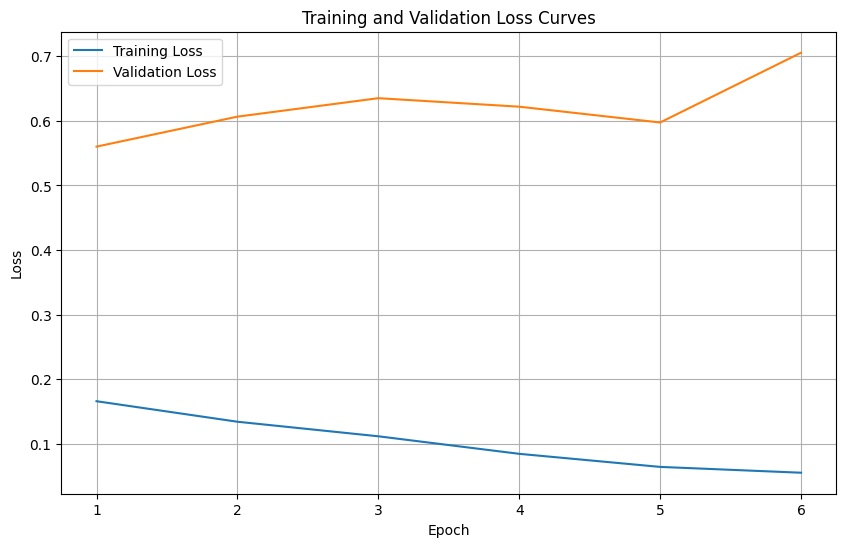

In [30]:
# plotting training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.savefig("loss_curves.png")
plt.show()

Test Loss: 0.5083, Test Accuracy: 83.92%


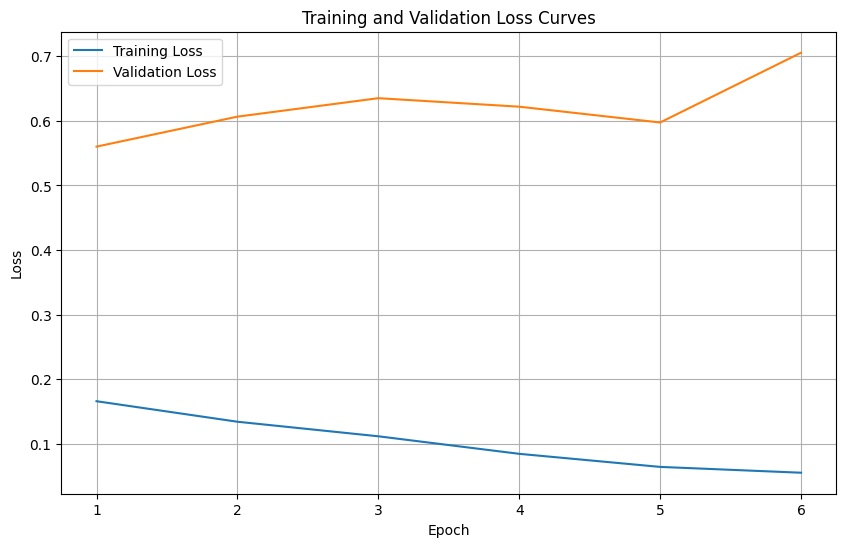


Classification Report:
               precision    recall  f1-score   support

       angry       0.91      0.76      0.83       140
       happy       0.86      0.93      0.89       148
     relaxed       0.79      0.81      0.80       146
         sad       0.81      0.86      0.83       138

    accuracy                           0.84       572
   macro avg       0.84      0.84      0.84       572
weighted avg       0.84      0.84      0.84       572



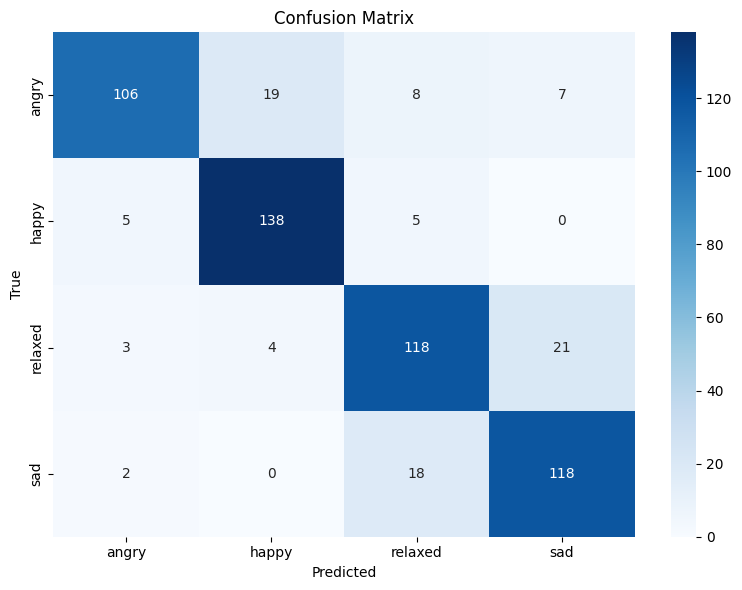

In [31]:
# load best model from training 
final_model.load_state_dict(torch.load(best_model_path)) 
final_model.to(device) 
final_model.eval() 
 
# initialise metrics 
correct = 0 
total = 0 
test_loss = 0.0 
all_preds = [] 
all_labels = [] 
 
with torch.no_grad(): 
    for images, labels in FULL_TEST_LOADER: 
        images, labels = images.to(device), labels.to(device) 
        outputs = final_model(images) 
        # for test loss 
        loss = criterion(outputs, labels) 
        test_loss += loss.item() * images.size(0) 
        # for accuracy 
        _, predicted = torch.max(outputs, 1) 
        total += labels.size(0) 
        correct += (predicted == labels).sum().item() 
 
        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu 
        all_labels.extend(labels.cpu().numpy()) 
 
test_loss = test_loss / len(FULL_TEST_LOADER.dataset) 
test_accuracy = correct / total 
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%") 
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100) 
 
# plotting training and validation loss curves 
if 'train_losses' in globals() and 'val_losses' in globals(): 
    plt.figure(figsize=(10, 6)) 
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss") 
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss") 
    plt.xlabel("Epoch") 
    plt.ylabel("Loss") 
    plt.title("Training and Validation Loss Curves") 
    plt.legend() 
    plt.grid(True) 
    loss_curve_path = os.path.join("..", "results", "SwinFicientNet_best_model", "loss_curves.png") #NOTE: specify by model name 
    plt.savefig(loss_curve_path) 
    plt.show() 
    logging.info("Training and Validation Loss curves saved to %s", loss_curve_path) 
else: 
    logging.warning("train_losses and val_losses are not defined. Skipping loss curves plot.") 
 
# generate and log classification report 
class_names = FULL_TEST_LOADER.dataset.classes 
report = classification_report(all_labels, all_preds, target_names=class_names) 
print("\nClassification Report:\n", report) 
logging.info("Classification Report:\n%s", report) 
 
# generate confusion matrix 
cm = confusion_matrix(all_labels, all_preds) 
 
# save confusion matrix as image 
fig, ax = plt.subplots(figsize=(8, 6)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax) 
plt.xlabel("Predicted") 
plt.ylabel("True") 
plt.title("Confusion Matrix") 
plt.tight_layout() 
 
conf_matrix_path = os.path.join("..", "results", "SwinFicientNet_best_model", "confusion_matrix.png") #NOTE: specify by model name 
fig.savefig(conf_matrix_path) 
plt.show(fig) 
 
logging.info("Confusion matrix saved to: %s", conf_matrix_path)
